# Project Overview

The following report outlines the process and outcomes of a product demand forecasting project utilizing three different machine learning algorithms: Linear Regression, Random Forest, and XGBoost. The project aimed to develop accurate models for predicting sales based on historical data, enabling better decision-making and resource allocation within the business.

# 1. Introduction:

Product Demand forecasting is a critical aspect of business operations as it helps organizations plan their inventory, allocate resources, and make informed decisions about marketing and production strategies. Machine learning algorithms have proven effective in capturing complex patterns in historical sales data and generating predictions for future sales.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

color_pallet = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('train.csv')

# 2. Understaing the Data:

In [3]:
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [5]:
df.shape

(913000, 4)

In [6]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [7]:
f'Total dates: {df[["date"]].nunique()[0]}'

'Total dates: 1826'

In [8]:
f'Total store: {df[["store"]].nunique()[0]}'

'Total store: 10'

In [9]:
f'Total items: {df[["item"]].nunique()[0]}'

'Total items: 50'

## Checking null data

In [10]:
df[df.isna().any(axis=1) | df.isnull().any(axis=1)]

,date,store,item,sales


## Grouping sales of all store by date

In [11]:
df = df.groupby('date').sum('sales')
df.index = pd.to_datetime(df.index)
df = df.drop(['store','item'], axis=1)
df.head()

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237


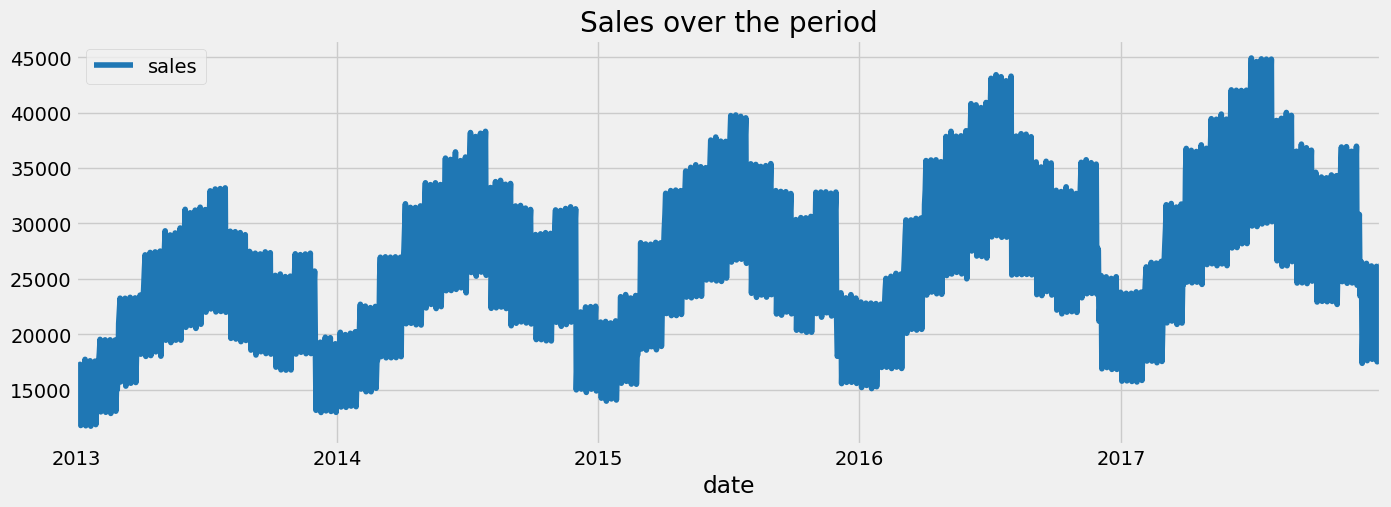

In [12]:
df.plot(
        # style='-',
        figsize=(15, 5),
        color=color_pallet[0],
        title='Sales over the period')
plt.show()

## Train and Test Split

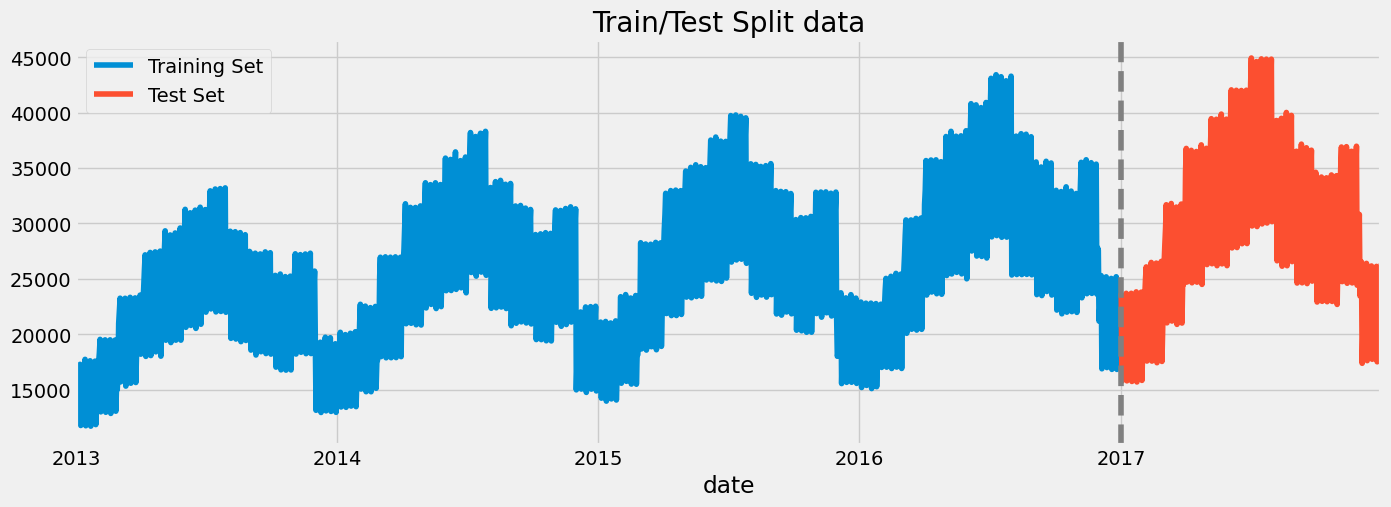

In [13]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split data')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='Gray', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

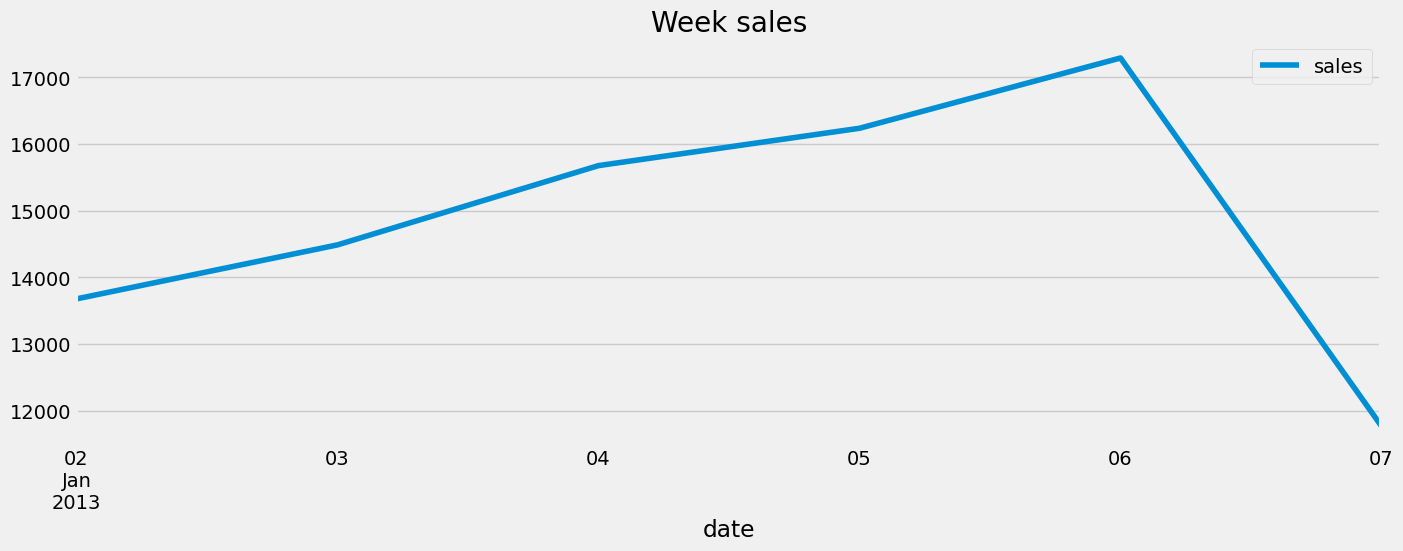

In [14]:
df.loc[(df.index > '01-01-2013') & (df.index < '01-08-2013')] \
    .plot(figsize=(15, 5), title='Week sales')
plt.show()

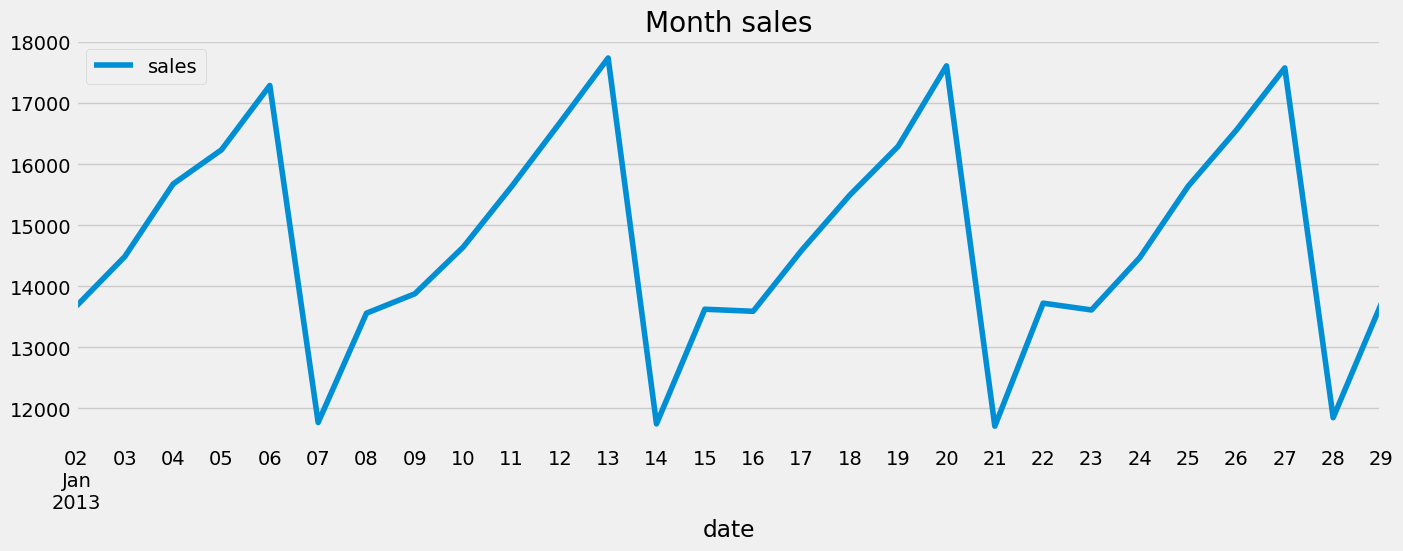

In [15]:
df.loc[(df.index > '01-01-2013') & (df.index < '01-30-2013')] \
    .plot(figsize=(15, 5), title='Month sales')
plt.show()

## Feature engineering

In [16]:
def create_features(df):
    """
    Creating time series features based on dataframe index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Visualizing feature and target Relationship

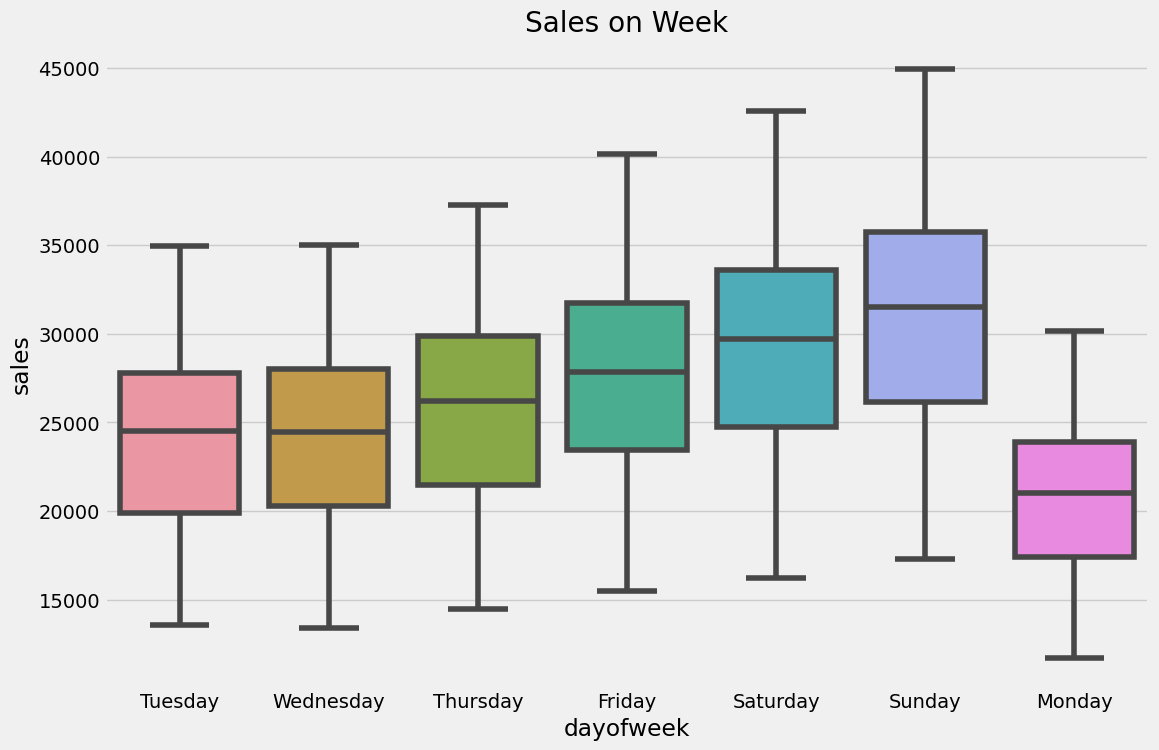

In [17]:
week_day_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}
df_temp = df.copy()
df_temp['dayofweek'] = df_temp['dayofweek'].map(lambda index: week_day_map[index])

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_temp, x='dayofweek', y='sales')
ax.set_title('Sales on Week')
plt.show()

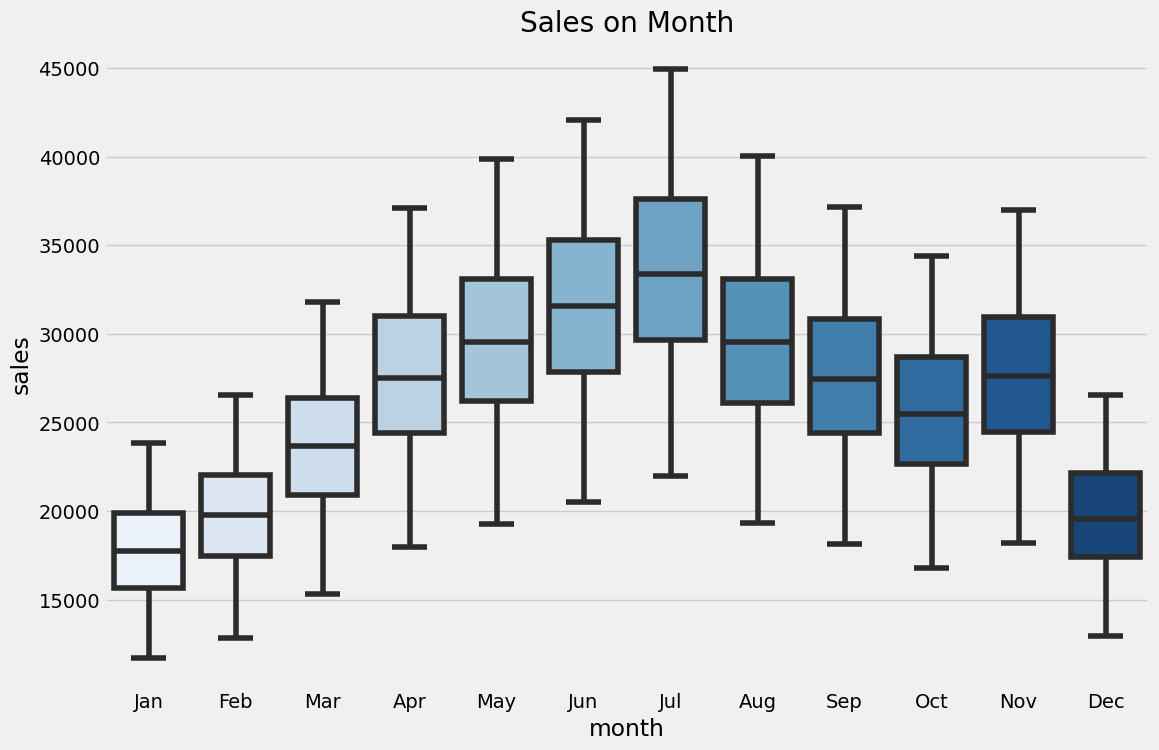

In [18]:
month_map = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}
df_temp = df.copy()
df_temp['month'] = df_temp['month'].map(lambda index: month_map[index])

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_temp, x='month', y='sales', palette='Blues')
ax.set_title('Sales on Month')
plt.show()

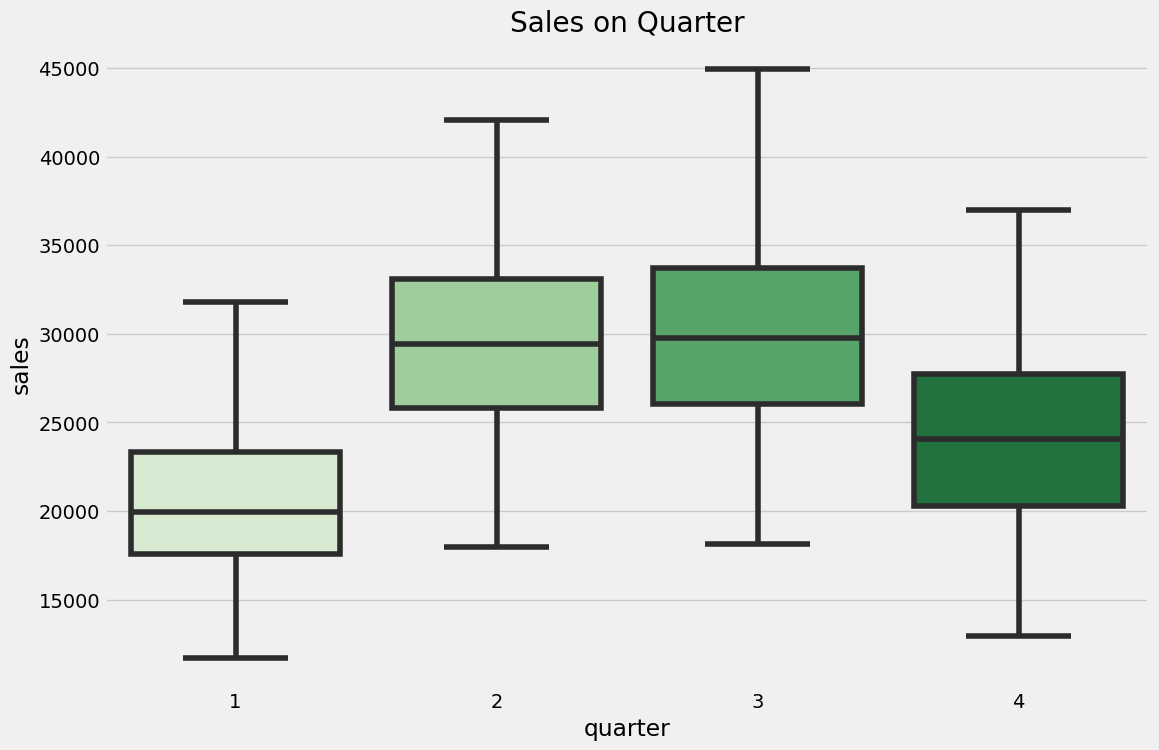

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_temp, x='quarter', y='sales', palette='Greens')
ax.set_title('Sales on Quarter')
plt.show()

# 3. Methodology:

Three distinct machine learning algorithms were implemented for the sales forecasting task:

**Linear Regression:** This algorithm establishes a linear relationship between the predictor variables and the target variable (sales). It serves as a baseline model due to its simplicity and interpretability.

**Random Forest:** Random Forest is an ensemble method that combines multiple decision trees to make predictions. It can capture non-linear relationships and interactions between variables, offering improved accuracy over Linear Regression.

**XGBoost:** XGBoost is a powerful gradient boosting algorithm known for its capability to handle complex relationships in data. It builds an ensemble of weak learners (decision trees) and optimizes their combination to produce accurate predictions.

# 4. Model Development and Evaluation:

The dataset was split into training and testing sets to train and evaluate the performance of each algorithm. Evaluation metrics such as Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R2 Score were used to assess the predictive accuracy of the models.

In [20]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Linear Regression

In [21]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

LinearRegression()

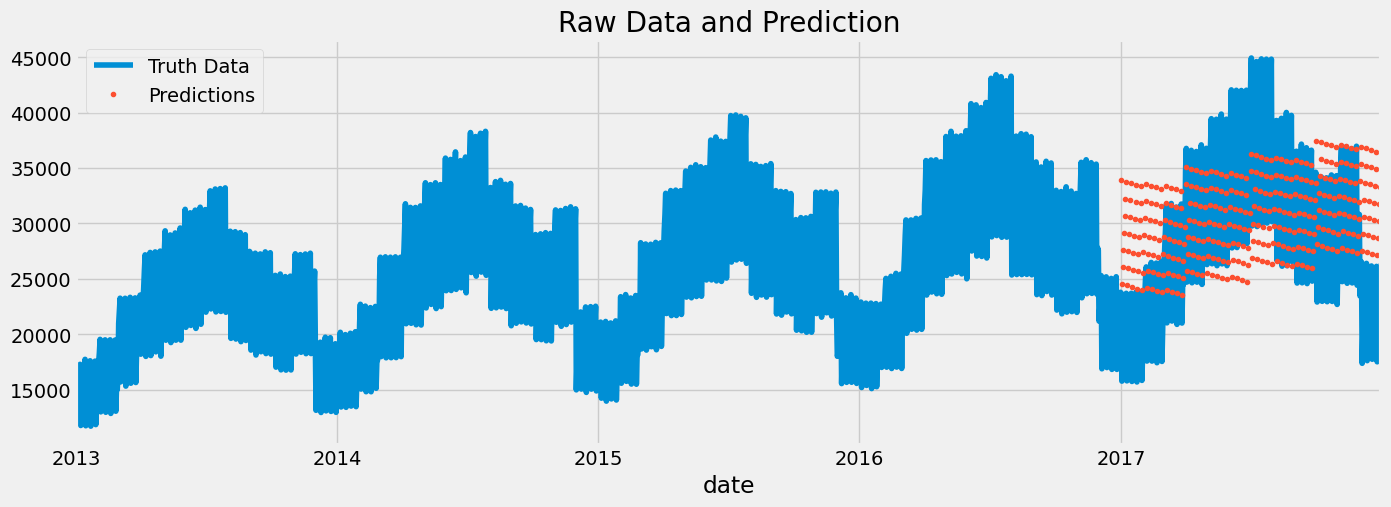

In [22]:
# test['prediction_lr'] = linreg_pred.predict(X_test)
test['prediction_lr'] = linreg_model.predict(X_test)
df = df.merge(test[['prediction_lr']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_lr'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [23]:
linreg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_lr']))
linreg_mae = mean_absolute_error(test['sales'], test['prediction_lr'])
linreg_r2 = r2_score(test['sales'], test['prediction_lr'])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

Linear Regression RMSE:  5346.264427842594
Linear Regression MAE:  4314.275653544825
Linear Regression R2 Score:  0.3245413312547968


## Random Forest

In [24]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

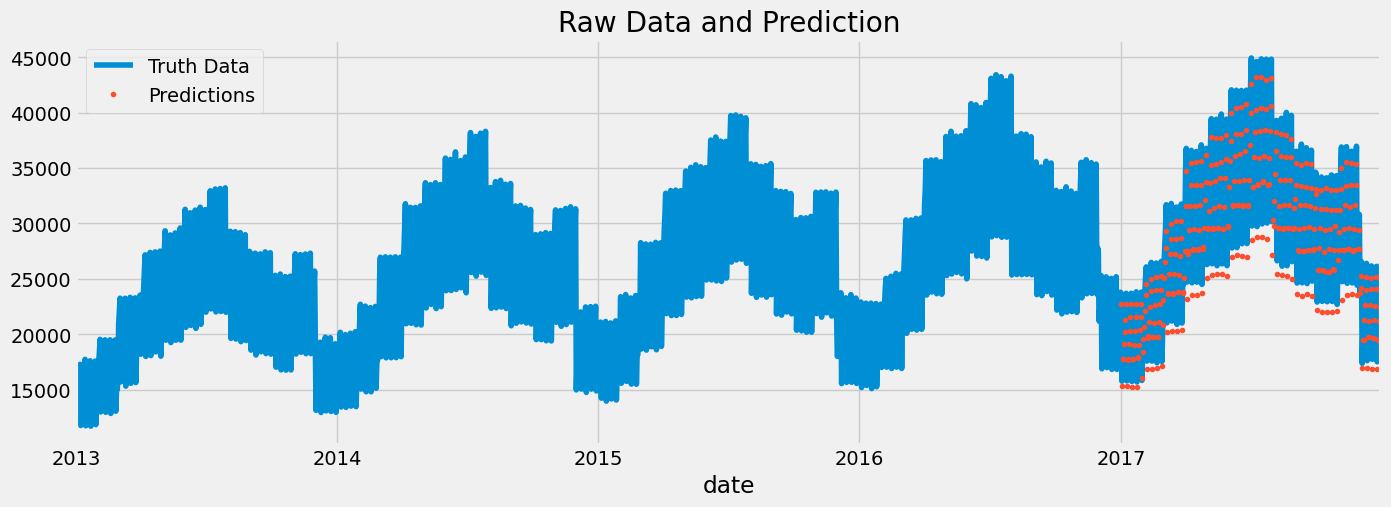

In [25]:
test['prediction_rf'] = rf_model.predict(X_test)
df = df.merge(test[['prediction_rf']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_rf'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [26]:
rf_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_rf']))
rf_mae = mean_absolute_error(test['sales'], test['prediction_rf'])
rf_r2 = r2_score(test['sales'], test['prediction_rf'])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  1218.7268740836475
Random Forest MAE:  1137.5399452054794
Random Forest R2 Score:  0.9648997116000458


## XGBOOST

In [27]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[09:59:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25781.11056	validation_1-rmse:29862.55802


[100]	validation_0-rmse:9897.87720	validation_1-rmse:13274.18406
[200]	validation_0-rmse:4177.89475	validation_1-rmse:6517.88338
[300]	validation_0-rmse:2101.67242	validation_1-rmse:3841.10162
[400]	validation_0-rmse:1294.72473	validation_1-rmse:2647.11584
[500]	validation_0-rmse:907.44465	validation_1-rmse:2058.22142
[600]	validation_0-rmse:670.69706	validation_1-rmse:1742.36133
[700]	validation_0-rmse:483.59878	validation_1-rmse:1527.62284
[800]	validation_0-rmse:366.45311	validation_1-rmse:1401.71649
[900]	validation_0-rmse:298.34850	validation_1-rmse:1328.47304
[999]	validation_0-rmse:262.89210	validation_1-rmse:1283.85660


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

## Feature Importance

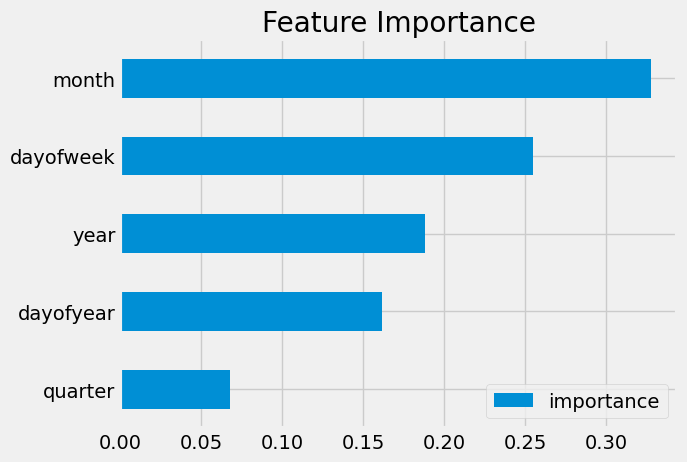

In [28]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

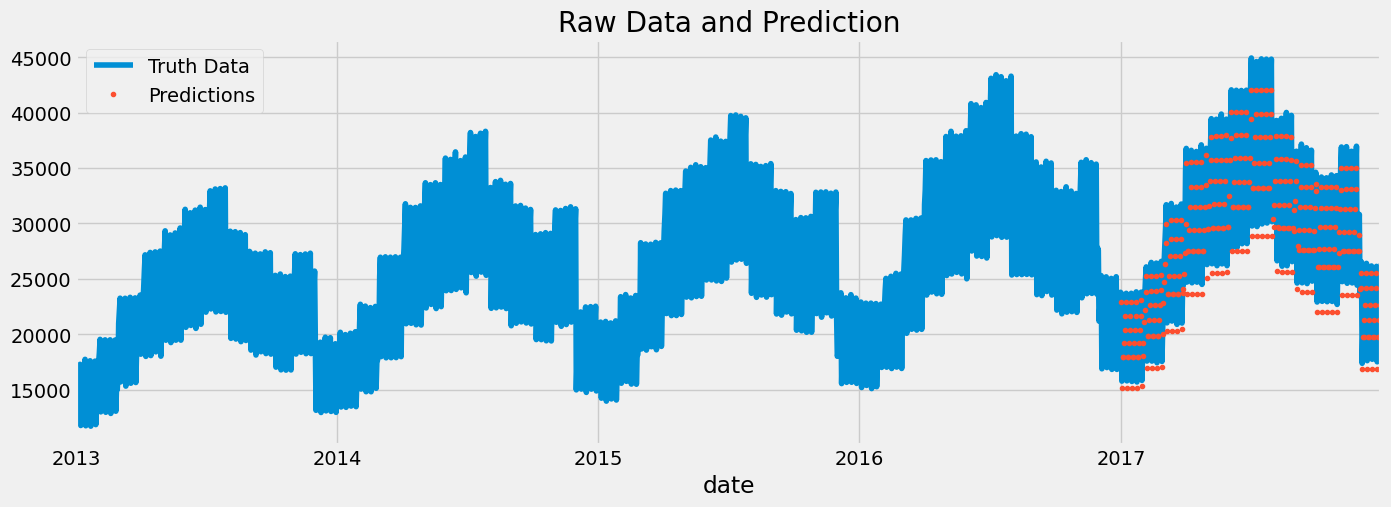

In [29]:
test['prediction_xg'] = reg.predict(X_test)
df = df.merge(test[['prediction_xg']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_xg'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

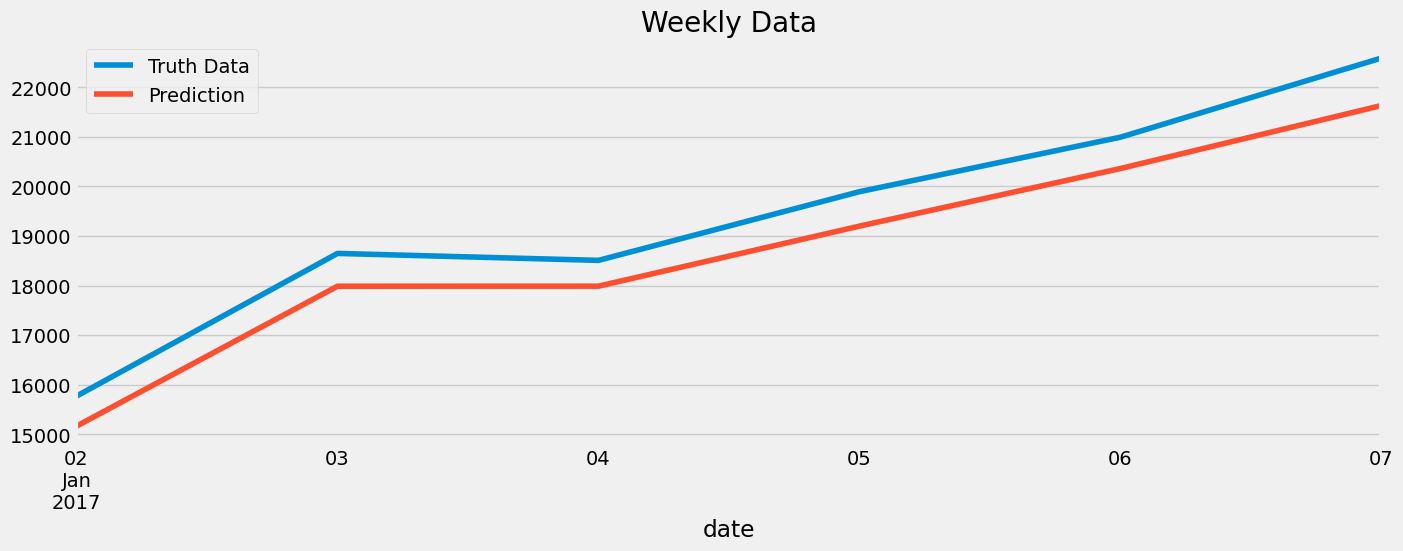

In [30]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['sales'] \
    .plot(figsize=(15, 5), title='Weekly Data')
df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['prediction_xg'] \
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score (RMSE)

In [31]:
# score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
# print(f'RMSE Score on Test set: {score:0.2f}')

xg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_xg']))
xg_mae = mean_absolute_error(test['sales'], test['prediction_xg'])
xg_r2 = r2_score(test['sales'], test['prediction_xg'])
print('Random Forest RMSE: ', xg_rmse)
print('Random Forest MAE: ', xg_mae)
print('Random Forest R2 Score: ', xg_r2)

Random Forest RMSE:  1283.8566006949254
Random Forest MAE:  1165.1742241010274
Random Forest R2 Score:  0.961047893790965


## Comparing Linear Regression, Random Forest, XG Boost

In [32]:
linreg_stats = [linreg_rmse, linreg_mae, linreg_r2]
rf_stats = [rf_rmse, rf_mae, rf_r2]
xgb_stats = [xg_rmse, xg_mae, xg_r2]

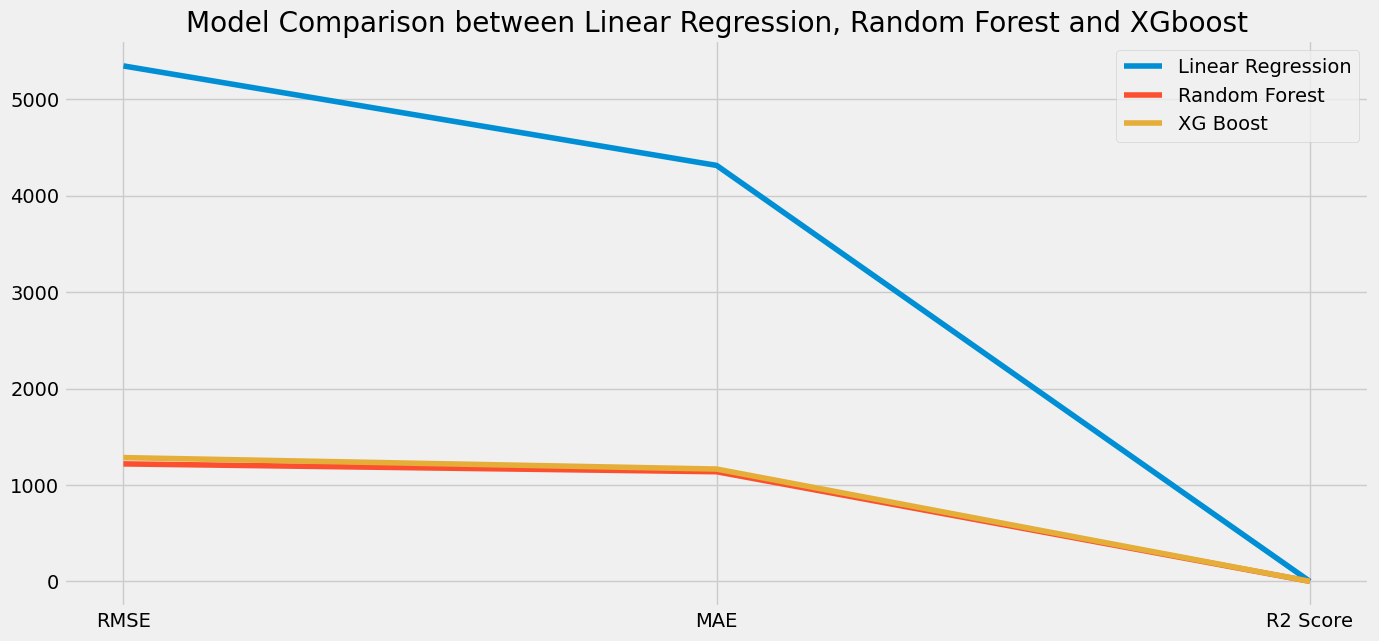

In [33]:
plt.figure(figsize=(15,7))
plt.plot(linreg_stats)
plt.plot(rf_stats)
plt.plot(xgb_stats)
plt.title("Model Comparison between Linear Regression, Random Forest and XGboost")
plt.xticks([0,1,2], labels=['RMSE','MAE','R2 Score'])
plt.legend(["Linear Regression", "Random Forest", "XG Boost"])
plt.show()

# 5. Results:

The results of the project revealed the following insights:

**Linear Regression** produced a moderate level of accuracy, suitable for simpler scenarios where relationships are relatively linear.

**Random Forest** outperformed Linear Regression, capturing non-linear patterns and interactions in the data effectively.

**XGBoost** demonstrated the highest predictive accuracy among the three algorithms, making it the preferred choice for sales forecasting in this project.

In [34]:
test['prediction'] = test['prediction_xg']
df['prediction'] = df['prediction_xg']

## Calculate Error
- Look at the worst and best predicted days

In [35]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['dates'] = test.index.date

In [36]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-04-01    4793.648438
2017-07-01    3131.398438
2017-07-02    2920.183594
2017-07-16    2840.183594
2017-07-30    2816.183594
2017-07-23    2815.183594
2017-07-22    2626.316406
2017-07-09    2594.183594
2017-06-01    2418.449219
2017-07-15    2283.316406
Name: error, dtype: float64

## Lets predict on future

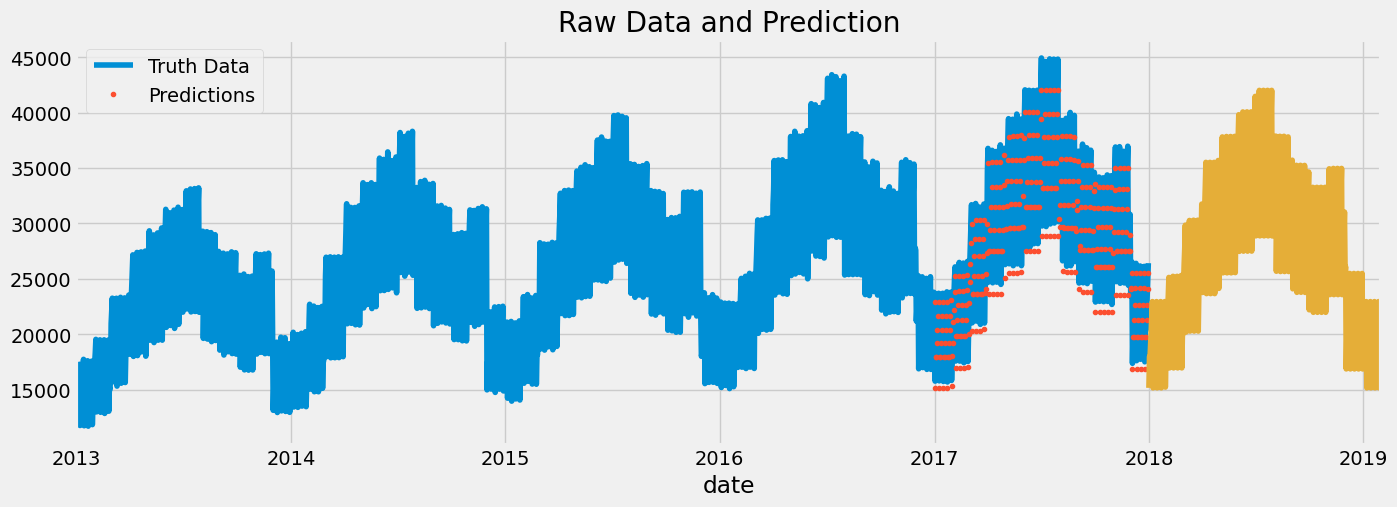

In [41]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2019-02-01"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

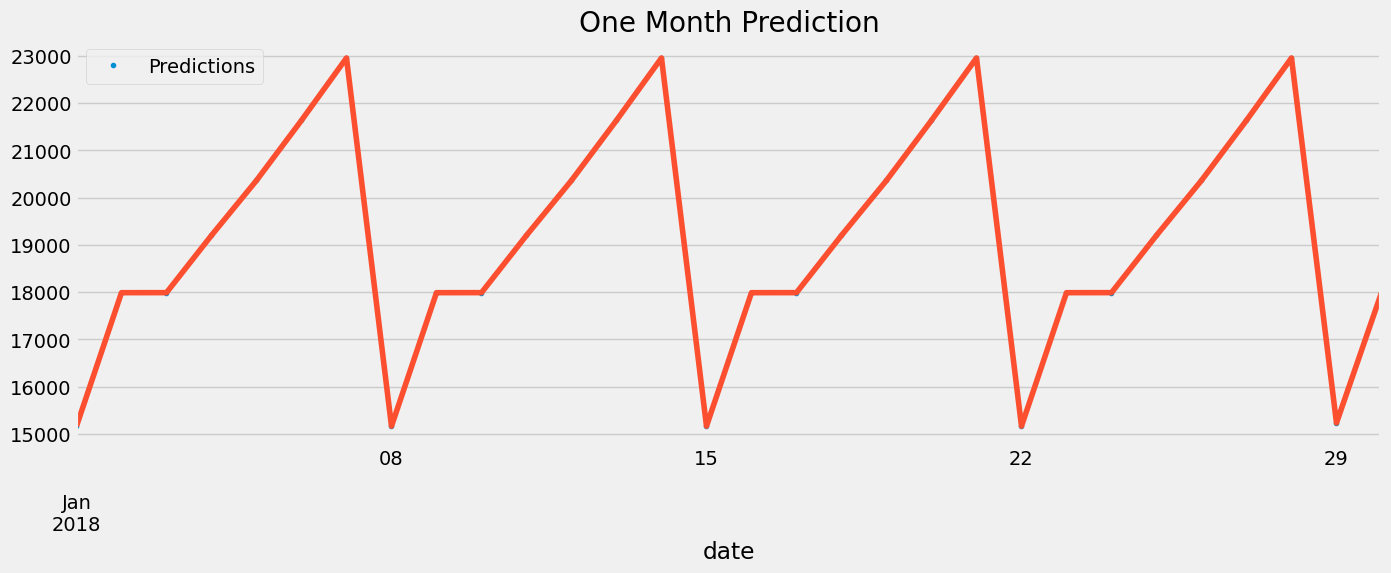

In [38]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2018-01-30"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = to_predict_feature['prediction'].plot(figsize=(15, 5), style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Predictions'])
ax.set_title('One Month Prediction')
plt.show()

# 6. Conclusion:

The product demand forecasting project successfully demonstrated the applicability of machine learning algorithms in predicting future sales. The models created using Linear Regression, Random Forest, and XGBoost showcased varying levels of accuracy, with XGBoost standing out as the most accurate and robust algorithm for this particular task. The insights gained from this project can empower businesses to make data-driven decisions, optimize resource allocation, and enhance overall operational efficiency. Future enhancements could involve exploring more advanced algorithms, incorporating additional relevant features, and fine-tuning model parameters for even better results.